# Crystallisation time and Plagioclase shape calibration in sills

Here we follow the procedure of Holness (2014) to calibrate the relationship between plagioclase shape and crystallisation time in sills using segmentation results with the DL method. The calibration itself will be performed using an MCMC approach to allow us to quantify the uncertainty in modelling based on the uncertainties in determining plagioclase shape. Uncertainties in the measured crystal aspect ratio are calculated using the bootstrap method utilized in the original publication by the author.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#function to calculate expected cooling time
def cooling_time(x, w, centre = True):
    x = np.abs(w/2 - x)
    k = 10**(-6)
    t =  0.1*((w**2)/k)*(1+np.cos((2*np.pi*x)/w))
    return t/(365.25*24*3600)

In [2]:
#details from Holness (2014) & Holness (2017)
marian = [2.14, 2.25, 3.21, 3.04, 3.21, 3.17, 3.05, 4.4, 4.09, 3.49, 2.68, 2.42, 2.06, 3.20, 3.42,3.17, 3.43,
         3.6,3.57,3,3.12,3.3]
marian_upper = [2.47,2.36,3.56,3.19,3.37,3.33,3.25,4.67,4.31,3.67,2.77,2.49,2.17,3.44,3.56,3.3,3.63,
               3.73,3.78,3.12,3.24,3.44]
marian_lower = [2,2.1,3.17,2.84,3.02,3.00,2.89,4.24,3.80,3.32,2.56,2.27,1.94,2.95,3.28,3,3.2,
               3.46,3.37,2.78,2.89,3.13]

w = [362, 362, 151,151,151,151,151,3.5,3.5,151,362,362,362, 151, 38.56,38.56,38.56,38.56,38.56,38.56,38.56,38.56]
x = [107,69.7,1,55,80,100,140, 1.69,1.06,124, 20,38.5,181.7, 21.8, 1.01,3.93,0.36,0.67,1.75,8.8,5.36,3.28]
names = ["ac", "ac", "kh", "kh", "kh", "kh", "kh", "rom", "rom", "kh", "ac", "ac", "ac", "kh", "ws","ws","ws","ws"
        ,"ws","ws","ws","ws"]

tc = cooling_time(np.asarray(x), np.asarray(w))

#pos = 0.5 means sample is at the edge/margin of intrusion, 0 means centre
pos = np.abs(np.asarray(w)/2 - np.asarray(x))/np.asarray(w)

### Loading in the results

Textural data - aspect ratio and size - are held in the "props" folder.

In [3]:
# NOTING that KH12 was misspelt as KH15 - it's actually KH12 
samples = ["AC38", "AC44", "KH1","KH15", "KH17", "KH22", "KH30", "ROM48_106", "ROM48-169", "KH27",
           "AC-55", "AC-49", "AC-13", "KH6", "E37042", "E37074", "E37083", "E37081", "E37079", "E37062",
           "E37052", "E37047"]

In [4]:
#load in the data itself
ar = []
size = []
for item in samples:
    data = np.load("sill_props/" + item + "_props.npz")
    ar.append(data["ar"])
    size.append(data["size"])

In [5]:
from scipy.stats import bootstrap
#perform bootstrap
conf_int = []
for item in ar:
    res = bootstrap((item,),np.mean, n_resamples=100, batch = 100)
    conf_int.append([res.confidence_interval[0], res.confidence_interval[1]])

#### See how the two datasets compare

In [6]:
m = [np.mean(ar[i]) for i in range(len(samples))]
from scipy.stats import pearsonr
pearsonr(m, marian)

PearsonRResult(statistic=0.8146085479350239, pvalue=3.928654523474888e-06)

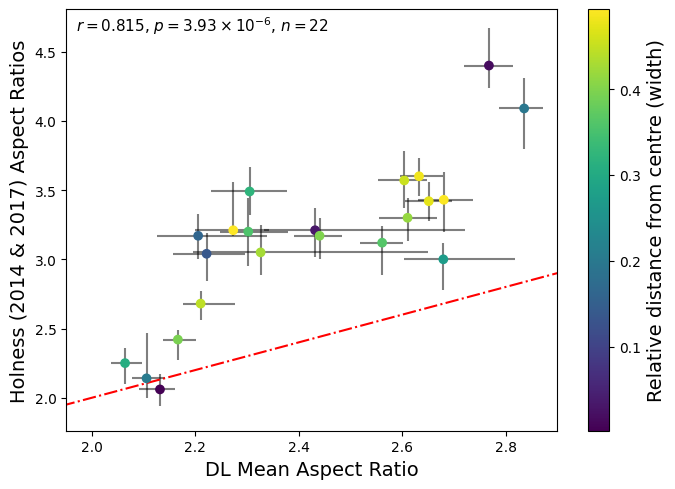

In [10]:
#Pearson's correlation coefficient suggests strong correlation
#No 1-to-1 match as you see below

fig, ax = plt.subplots(1,1,figsize = (7,5))

ax.errorbar(m, marian,
 xerr=[m-np.asarray(conf_int)[:,0],np.asarray(conf_int)[:,1]-m],
 yerr = [np.asarray(marian)-np.asarray(marian_lower), np.asarray(marian_upper)-np.asarray(marian)],
 fmt = '', linestyle = '', color = 'k', alpha = 0.5, zorder = 1)
mappable = ax.scatter(m, marian, c = pos, zorder = 100)
cbar = plt.colorbar(mappable)
cbar.set_label("Relative distance from centre (width)", size = 14)
ax.plot([1.9,3.5], [1.9,3.5], 'r-.')
fig.tight_layout()
ax.set_xlim([1.95,2.9])
ax.set_xlabel("DL Mean Aspect Ratio", size = 14)
ax.set_ylabel("Holness (2014 & 2017) Aspect Ratios", size = 14)
ax.text(1.97, 4.65,r"$r = 0.815$, $p = 3.93\times 10^{-6}$, $n =22$", size = 11)
fig.tight_layout()
fig.savefig("fig9.pdf", dpi = 500)

#### Calibration of expected relationship

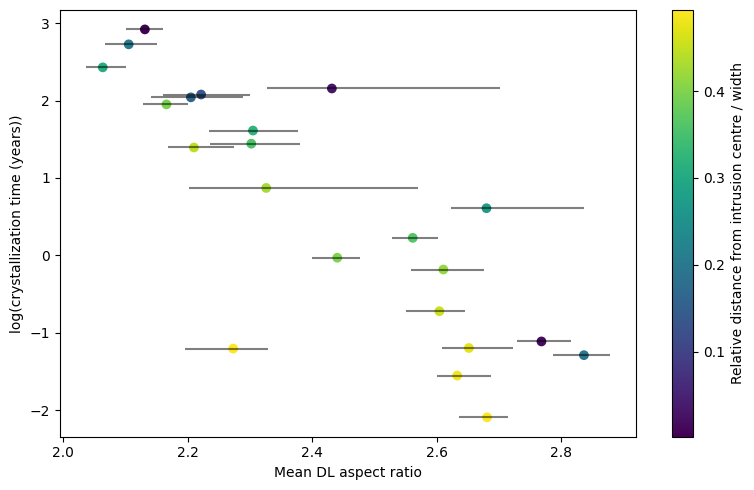

In [8]:
m = [np.mean(ar[i]) for i in range(len(samples))]

fig, ax = plt.subplots(1,1,figsize = (8,5))

ax.errorbar(m, np.log10(tc),
 xerr=[m-np.asarray(conf_int)[:,0],np.asarray(conf_int)[:,1]-m],
 fmt = '', linestyle = '', color = 'k', alpha = 0.5)
mappable = plt.scatter(m, np.log10(tc),c=pos, cmap = "viridis")
cbar = plt.colorbar(mappable)
cbar.set_label("Relative distance from intrusion centre / width")
ax.set_ylabel("log(crystallization time (years))")
ax.set_xlabel("Mean DL aspect ratio")
fig.tight_layout()

In [9]:
#get rid of samples too close to margin as done by Holness (2014)
filter_arr = pos <0.48
err = 0.5*(np.asarray(conf_int)[:,1]- np.asarray(conf_int)[:,0])
conf_int_mean = np.mean(conf_int, axis = 1)

Here we will perform the MCMC fitting procedure.

We impose a Gaussian likelihood function as we can safely assume the uncertainties on x follow a normal distribution invoking the central limit theorem on bootstrapping. We set fairly uninformative priors on both m and c with the parameters set to lie in the intervals [-10, 0] and [0, 25] repesctively. 

In [10]:
def linear(x, theta):
    m1, c1 = theta
    y = m1*x + c1
    return y
class logfuncs():
     
    def __init__(self,pmin, pmax):
          #super().__init___(pmin, pmax)
          self.pmin = pmin
          self.pmax = pmax


    def log_prior(self,theta):
        m, c = theta
        if self.pmin[0] < m < self.pmax[0] and self.pmin[1] < c < self.pmax[1]:
            return 0.0
        return -np.inf

    def log_likelihood(self,theta, x, y, xerr):
        # eval model
        ymodel = linear(x, theta)
        var = xerr*theta[0]
        # calc sos
        ss = -0.5*sum(np.divide((ymodel-y)**2,var**2) + np.log(var**2))
        return ss
    

    def log_probability(self,theta, x, y, yerr):
        lp = self.log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.log_likelihood(theta, x, y, yerr)

In [12]:
def emcee_lin_xerr(x,y,yerr, params, pmin, pmax, nsimu = 5e4):
    names   = ["m1", "c1"]
    funcs = logfuncs(pmin,pmax)
    import emcee
    from multiprocessing import Pool
    pos = np.asarray(params) + 1e-5 * np.random.randn(5, 2)
    nwalkers, ndim = pos.shape

    filename = "kms25.h5"
    backend = emcee.backends.HDFBackend(filename)
    backend.reset(nwalkers, ndim)
    #with Pool() as pool:
    sampler = emcee.EnsembleSampler(
    nwalkers, ndim, funcs.log_probability, args=(x, y, yerr), backend = backend)
    sampler.run_mcmc(pos, int(nsimu), progress=True)

    #samples = sampler.get_chain()
    #import pickle
    #with open("emcee_res.pkl", "wb") as f:
    #     pickle.dump(samples, f)
    return sampler

In [13]:
results = emcee_lin_xerr(conf_int_mean[filter_arr], np.log10(tc[filter_arr]), err[filter_arr], [-1,1], [-20,0], [20, 40])

100%|██████████| 50000/50000 [09:02<00:00, 92.12it/s] 


In [14]:
flat_samples = results.get_chain(discard=5000, thin=1, flat=True)

In [15]:
import pickle
with open("mcmc_results.pkl", "wb") as f:
    pickle.dump(flat_samples, f)

See joint posterior distribution for the two parameters below with the chains visualized underneath. The chains do not show any evidence of the burn-in period the model removed automatically and show the fit managed to converge nicely.

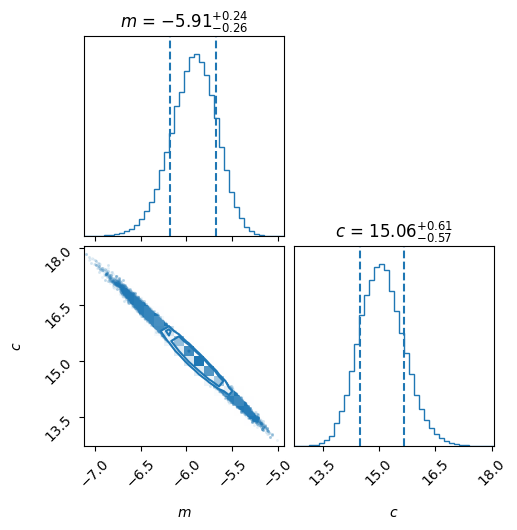

In [26]:
import corner
fig =corner.corner(flat_samples,
labels=[
        r"$m$",
        r"$c$",
        r"$log(f)$"
    ],
    quantiles=(0.16, 0.84),
    show_titles=True,
    title_kwargs={"fontsize": 12}, color = "tab:blue", hist_bin_factor = 2)
fig.savefig("mcmc_posterior.png", dpi = 300)

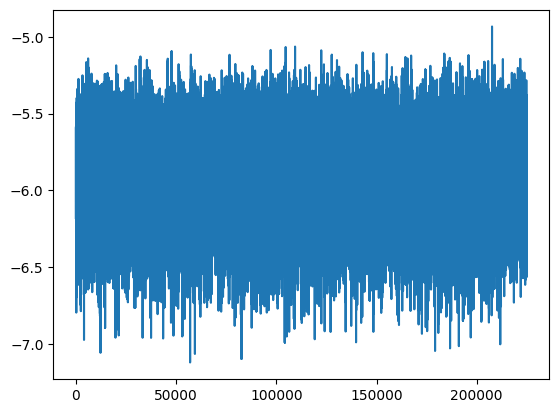

In [17]:
#samples for m
plt.plot(range(len(flat_samples[:,0])),flat_samples[:,0] )

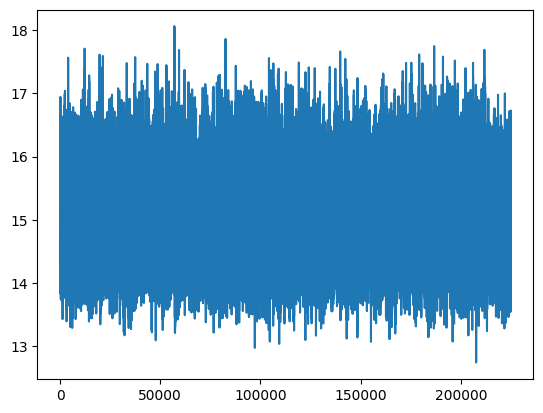

In [18]:
#samples for c
plt.plot(range(len(flat_samples[:,1])),flat_samples[:,1]  )

In [19]:
#function to run inference using the mcmc fits above - outputs mean and std

def mcmc_inference(x, post_m, post_c, return_full = False):
    x = np.asarray(x)
    y = x*post_m.reshape(-1,1) + post_c.reshape(-1,1)
    if return_full is True:
        return y
    else:
        return np.mean(y, axis = 0), np.std(y, axis = 0)

In [20]:
x_vals = np.linspace(1.9,3,100)
yr = mcmc_inference(x_vals,flat_samples[:,0], flat_samples[:,1], True)

In [21]:
yr.shape

(225000, 100)

In [22]:
ye1 = np.quantile(np.sort(yr, axis = 1), 0.16, axis = 0)
ye2 = np.quantile(np.sort(yr, axis = 1), 0.84, axis = 0)

In [23]:
ye3 = np.quantile(np.sort(yr, axis = 1), 0.025, axis = 0)
ye4 = np.quantile(np.sort(yr, axis = 1), 0.975, axis = 0)
ye5 = np.quantile(np.sort(yr, axis = 1), 0.005, axis = 0)
ye6 = np.quantile(np.sort(yr, axis = 1), 0.995, axis = 0)

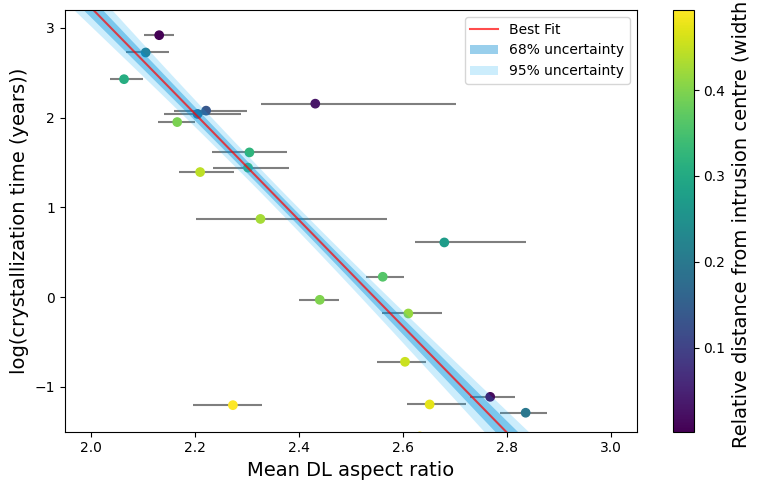

In [25]:
x_vals = np.linspace(1.9,3,100)
y, y_std = mcmc_inference(x_vals, flat_samples[:,0], flat_samples[:,1])

# Plot everything
fig, ax = plt.subplots(1,1,figsize = (8,5))

ax.errorbar(m, np.log10(tc),
 xerr=[m-np.asarray(conf_int)[:,0],np.asarray(conf_int)[:,1]-m],
 fmt = '', linestyle = '', color = 'k', alpha = 0.5, zorder = 0)
mappable = plt.scatter(m, np.log10(tc),c=pos, cmap = "viridis", zorder = 1)
cbar = plt.colorbar(mappable)

ax.plot(x_vals,y, label="Best Fit", c="r", alpha =0.7)
plt.fill_between(x_vals, ye2[::-1], ye1[::-1], 
                 label=r"68% uncertainty", fc="#0288D1", alpha=0.4)
plt.fill_between(x_vals, ye4[::-1], ye3[::-1], 
                 label=r"95% uncertainty", fc="#03A9F4", alpha=0.2)
#plt.fill_between(x_vals, ye6[::-1], ye5[::-1], 
#                 label=r"99% uncertainty", fc="#0288D1", alpha=0.1)
ax.legend(loc = "upper right")
cbar.set_label("Relative distance from intrusion centre (width)", size = 14)
ax.set_ylabel("log(crystallization time (years))", size = 14)
ax.set_xlabel("Mean DL aspect ratio", size = 14)
ax.set_ylim([-1.5,3.2])
ax.set_xlim(1.95,3.05)
fig.tight_layout()
fig.savefig("holness_calibration.png", dpi = 500)